<h1 style="text-align:center;">Practical session 3</h1>
<h2 style="text-align:center;">Biomedical Data Science</h2>
<h3 style="text-align:center;">Lucas Fayolle & Jose Valero</h3>

# Block 0. Libraries

In [1]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
import itertools
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from sklearn.preprocessing import label_binarize
import joblib

# Block I. Data preparation

## 1. Load your data and extract basic data descriptors using the pandas profiling package

### 1.1 Load Data

After importing the required libraries, we load the dataset. We read the CSV file and perform initial data cleaning. The dataset is filtered to include only specific columns of interest (we delete the index because pandas creates one automatically), and we replace commas with periods in numeric columns to ensure proper numerical formatting.

In [3]:
df = pd.read_csv("Metabolite_concentrations_diagnosis.csv", sep = ";", usecols=range(1,17))

metabolite_columns = df.columns[df.colutmns != 'TYPE']
df[metabolite_columns] = df[metabolite_columns].apply(lambda x: x.str.replace(',', '.').astype(float))

df

,METABOLITE 0,METABOLITE 1,METABOLITE 2,METABOLITE 3,METABOLITE 4,METABOLITE 5,METABOLITE 6,METABOLITE 7,METABOLITE 8,METABOLITE 9,METABOLITE 10,METABOLITE 11,METABOLITE 12,METABOLITE 13,METABOLITE 14,TYPE
0,0.322695,0.575024,0.742645,0.635958,0.544804,0.785336,0.885756,0.577938,0.123017,0.701689,0.731254,0.846980,3.551957,3.742832,1.719949,MENINGIOMA
1,0.457408,0.764700,0.444451,0.451300,0.388213,0.401597,0.382574,0.407632,0.715072,1.216084,1.204490,2.329079,3.179366,3.117351,1.252479,MENINGIOMA
2,1.452870,1.152910,0.647735,0.622494,0.648020,0.826787,0.797439,0.695269,0.850328,0.910488,0.914841,1.805095,2.156737,2.152553,1.081571,MENINGIOMA
3,0.157588,0.314415,0.251613,0.186498,0.100556,0.287618,0.334349,0.213802,0.305852,0.754096,0.627211,1.566407,4.274654,4.210731,1.128131,MENINGIOMA
4,0.368681,0.206993,0.211521,0.034699,0.164187,0.364590,0.340892,0.110287,0.260206,0.531801,0.496068,0.654805,4.070067,4.324002,1.350580,MENINGIOMA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1.146621,1.952639,1.240700,1.216044,0.873140,1.341280,1.344396,0.566293,0.714166,2.140718,2.027257,0.735564,0.975908,1.080736,0.984968,GLIOBLASTOMA
87,1.304585,1.048878,1.456252,1.391773,0.716365,1.224394,1.465654,1.349410,0.868388,2.699551,2.731945,0.795505,0.725981,0.700257,0.622597,GLIOBLASTOMA
88,1.648198,1.965646,0.913688,0.925384,1.040036,1.344963,1.313133,0.635587,0.974705,1.477950,1.421918,0.643054,1.233130,1.254060,1.052289,GLIOBLASTOMA
89,0.524946,0.711819,0.459294,0.450123,0.532891,0.464126,0.539442,0.431146,0.263541,1.087815,1.003663,0.888594,2.263318,2.392848,2.219673,GLIOBLASTOMA


### 1.2 Exploratory analysis

Once the data is loaded and cleaned, we proceed to generate an exploratory data profile report. This report provides a summary of data distributions, feature statistics, and highlights any potential issues. It can be useful to understand the dataset before proceeding with model building (currently commented out to save processing time, but available as HTML file in PoliformaT task).

In [4]:
# profile = ProfileReport(df, title='Metabolite Concentrations Diagnosis Report')
# profile.to_file('metabolite_profile_report.html')

Some important insights extracted from the report for use in later sections are as follows:
  - **Outliers in Metabolites**. There are some extreme values in metabolite concentrations that should be removed to improve model performance.
  - **No Missing Values**. The dataset contains no missing values, so imputation methods are not necessary.
  - **Correlation Among Variables**. The correlation between different variables is summarized below:
    
    <div align="center" style="margin-top: 20px; margin-bottom: 20px;">
      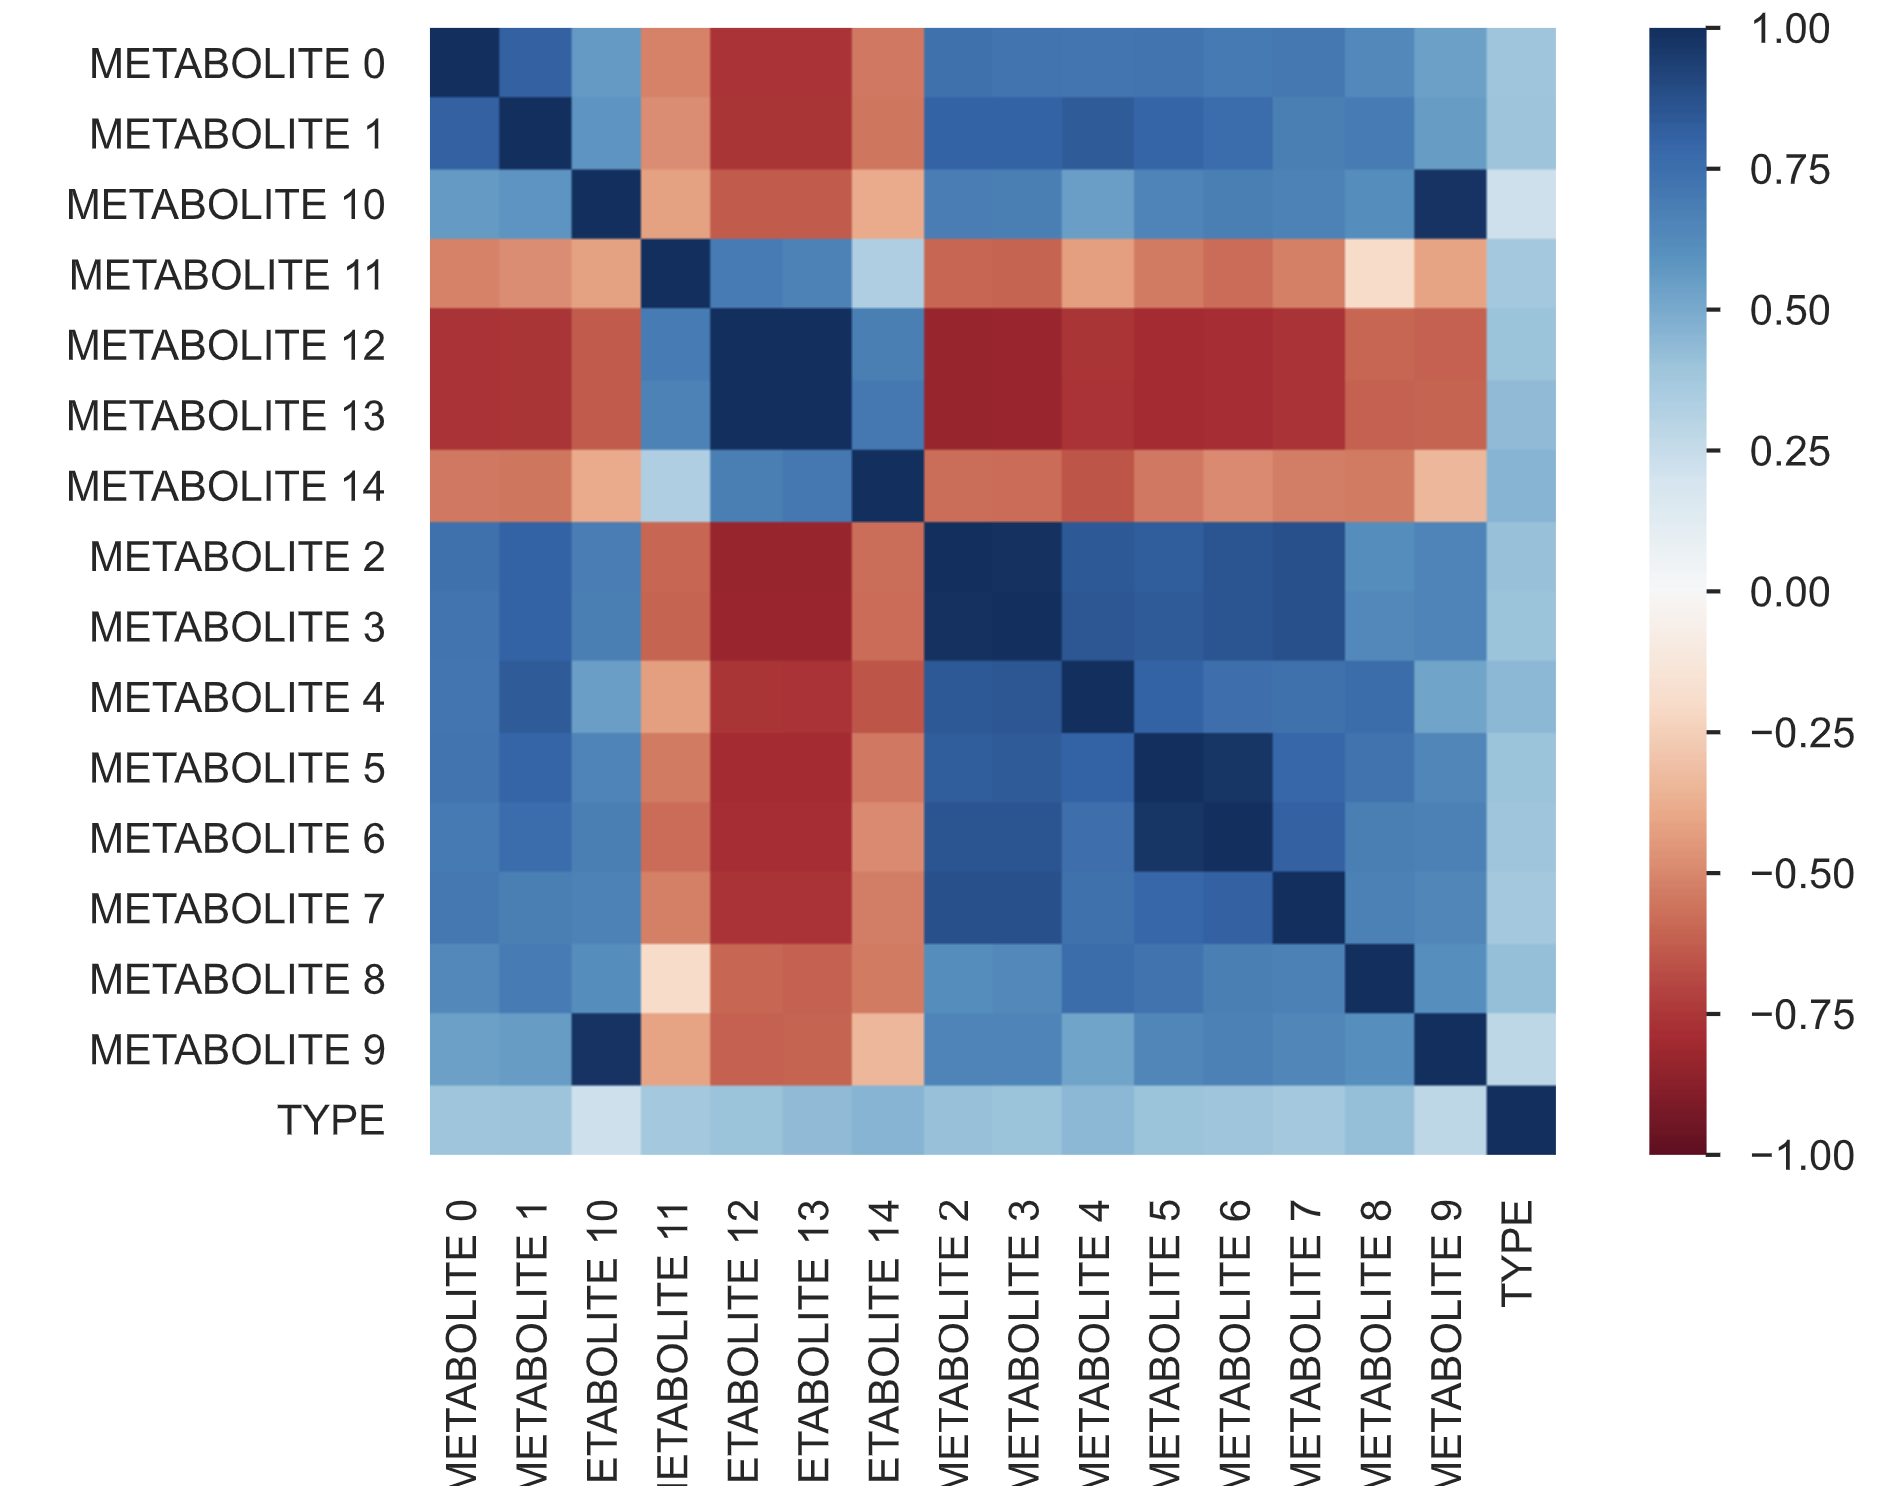
    </div>
  
  - **Class Imbalance**. There is an imbalance in the target variable which could be important when training the model.
    
    <div align="center" style="margin-top: 20px; margin-bottom: 20px;">
      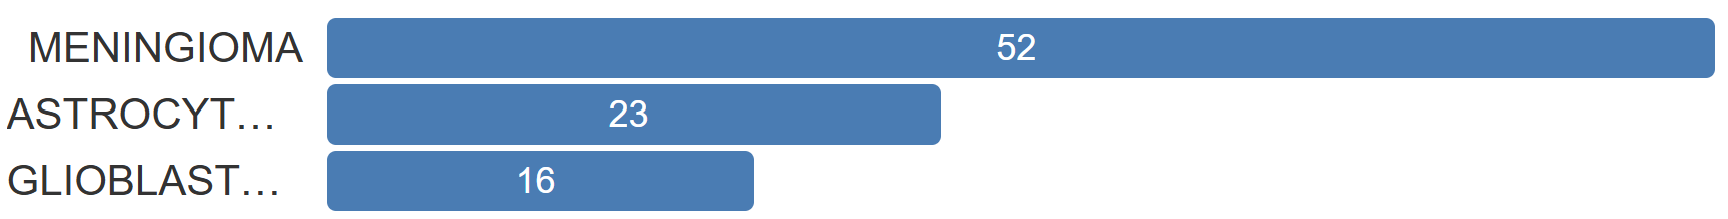
    </div>

## 2. Create an auxiliary one hot encoded variable for each of the 3 types of brain tumors.

The next step involves preparing the categorical data for machine learning by encoding the `'TYPE'` column using one-hot encoding. We also keep a copy of the original `'TYPE'` values for using it later (since `'get_dummies'` deletes the original variable).

In [5]:
df['TYPE_ORG'] = df['TYPE']
df = pd.get_dummies(df, columns=['TYPE'])
df

,METABOLITE 0,METABOLITE 1,METABOLITE 2,METABOLITE 3,METABOLITE 4,METABOLITE 5,METABOLITE 6,METABOLITE 7,METABOLITE 8,METABOLITE 9,METABOLITE 10,METABOLITE 11,METABOLITE 12,METABOLITE 13,METABOLITE 14,TYPE_ORG,TYPE_ASTROCYTOMA,TYPE_GLIOBLASTOMA,TYPE_MENINGIOMA
0,0.322695,0.575024,0.742645,0.635958,0.544804,0.785336,0.885756,0.577938,0.123017,0.701689,0.731254,0.846980,3.551957,3.742832,1.719949,MENINGIOMA,False,False,True
1,0.457408,0.764700,0.444451,0.451300,0.388213,0.401597,0.382574,0.407632,0.715072,1.216084,1.204490,2.329079,3.179366,3.117351,1.252479,MENINGIOMA,False,False,True
2,1.452870,1.152910,0.647735,0.622494,0.648020,0.826787,0.797439,0.695269,0.850328,0.910488,0.914841,1.805095,2.156737,2.152553,1.081571,MENINGIOMA,False,False,True
3,0.157588,0.314415,0.251613,0.186498,0.100556,0.287618,0.334349,0.213802,0.305852,0.754096,0.627211,1.566407,4.274654,4.210731,1.128131,MENINGIOMA,False,False,True
4,0.368681,0.206993,0.211521,0.034699,0.164187,0.364590,0.340892,0.110287,0.260206,0.531801,0.496068,0.654805,4.070067,4.324002,1.350580,MENINGIOMA,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1.146621,1.952639,1.240700,1.216044,0.873140,1.341280,1.344396,0.566293,0.714166,2.140718,2.027257,0.735564,0.975908,1.080736,0.984968,GLIOBLASTOMA,False,True,False
87,1.304585,1.048878,1.456252,1.391773,0.716365,1.224394,1.465654,1.349410,0.868388,2.699551,2.731945,0.795505,0.725981,0.700257,0.622597,GLIOBLASTOMA,False,True,False
88,1.648198,1.965646,0.913688,0.925384,1.040036,1.344963,1.313133,0.635587,0.974705,1.477950,1.421918,0.643054,1.233130,1.254060,1.052289,GLIOBLASTOMA,False,True,False
89,0.524946,0.711819,0.459294,0.450123,0.532891,0.464126,0.539442,0.431146,0.263541,1.087815,1.003663,0.888594,2.263318,2.392848,2.219673,GLIOBLASTOMA,False,True,False


## 3. Split your data using a holdout methodology considering odds of 70:30

With the data cleaned and transformed, we split it into training and test sets. This ensures that the model can be trained on one part of the data and evaluated on a separate, unseen portion to gauge its performance. **Stratification** is used to maintain the same distribution of classes in both sets.

In [6]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=23, stratify=df['TYPE_ORG'])

## 4. Perform robust scaling on each of the datasets generated in 3)

To prepare the numerical features for model training, we scale them using `'RobustScaler'`. This scaler is particularly useful because it is less sensitive to outliers. Scaling helps standardize the range of features, which improves model convergence during training.

In [7]:
exclude_cols = ['TYPE_ORG'] + [col for col in train_df.columns if col.startswith('TYPE_')]
numeric_cols = [col for col in train_df.columns if col not in exclude_cols]

scaler = RobustScaler(quantile_range=(2.5, 97.5))

scaler.fit(train_df[numeric_cols])

train_df_scaled = train_df.copy()
test_df_scaled = test_df.copy()

train_df_scaled[numeric_cols] = scaler.transform(train_df[numeric_cols])
test_df_scaled[numeric_cols] = scaler.transform(test_df[numeric_cols])

We save the fitted `'RobustScaler'` using `'joblib.dump()'`. This allows us to reuse the scaler later, such as during the prediction phase in block III of the application. By saving the scaler, we ensure consistent scaling of input data when making predictions, which is crucial for maintaining model accuracy.

In [35]:
# joblib.dump(scaler, 'robust_scaler.joblib')

Now we define the features (`X`) and target labels (`y`) for both the training and test sets. This step separates the input data (features) from the output labels (targets), making it easier to train the machine learning model.

In [8]:
X_train = train_df_scaled.drop(columns=['TYPE_ORG', 'TYPE_ASTROCYTOMA', 'TYPE_GLIOBLASTOMA', 'TYPE_MENINGIOMA'])
X_test = test_df_scaled.drop(columns=['TYPE_ORG', 'TYPE_ASTROCYTOMA', 'TYPE_GLIOBLASTOMA', 'TYPE_MENINGIOMA'])

y_train = train_df_scaled[['TYPE_ASTROCYTOMA', 'TYPE_GLIOBLASTOMA', 'TYPE_MENINGIOMA']]
y_test = test_df_scaled[['TYPE_ASTROCYTOMA', 'TYPE_GLIOBLASTOMA', 'TYPE_MENINGIOMA']]

# Block II. Model training and selection

## 1. Choose a proper evaluation metric suitable for the problem

Before building the model, it is essential to select an **evaluation metri**c that aligns with the nature of our problem. 

Based on the exploratory data analysis, we observed an imbalance in class distribution:

- **MENINGIOMA**: 52 samples
- **ASTROCYTOMA**: 23 samples
- **GLIOBLASTOMA**: 16 samples

Given this imbalance, we require a metric that remains unbiased by the unequal sample sizes across classes and ensures fair treatment of all classes. In this context, the **Macro Averaged F1-Score** is particularly suitable because it:

- Gives equal weight to each class, irrespective of sample counts.
- Combines precision and recall, providing a balanced assessment of model performance across all classes.

## 2. Run some experiments: 

We then define a function to create the neural network model using the Keras `Sequential` API. This model has multiple hidden layers with ReLU activation to introduce non-linearity, and an output layer with softmax activation to handle multi-class classification. The Adam optimizer is chosen for efficient gradient descent.

In [9]:
def create_model(learning_rate=0.001, architecture=[64, 32], input_dim=None):
    model = Sequential()

    for idx, units in enumerate(architecture):
        if idx == 0:
            model.add(Dense(units, input_dim=input_dim, activation='relu'))
        else:
            model.add(Dense(units, activation='relu'))

    model.add(Dense(3, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy')
    return model

Next, we define a function to train and evaluate the model. The function uses the training set to fit the model and then makes predictions on the test set. The performance of the model is assessed using the F1 macro score, which gives a balanced evaluation across all classes.

In [10]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, batch_size=32, epochs=10):
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    return f1_macro

Next, we will perform some experiments to study the influence of learning rate, batch size, neural network architecture and number of iterations (epochs):

### 2.1 Learning rate

First, we iterate over a list of different learning rates, train the model for each, and record the F1 macro scores. The goal is to determine which learning rate results in the best model performance.

In [11]:
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
results_lr = []

input_dim = X_train.shape[1]

for lr in learning_rates:
    model = create_model(learning_rate=lr, input_dim=input_dim)
    f1_macro = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
    results_lr.append({'learning_rate': lr, 'f1_macro': f1_macro})
    print(f"Learning rate: {lr}, F1 Macro Score: {f1_macro:.4f}")

1/1 [==============================] - 0s 71ms/step
Learning rate: 1e-05, F1 Macro Score: 0.3476
1/1 [==============================] - 0s 42ms/step
Learning rate: 0.0001, F1 Macro Score: 0.3984
1/1 [==============================] - 0s 31ms/step
Learning rate: 0.001, F1 Macro Score: 0.6227
1/1 [==============================] - 0s 56ms/step
Learning rate: 0.01, F1 Macro Score: 0.7383
1/1 [==============================] - 0s 31ms/step
Learning rate: 0.1, F1 Macro Score: 0.8755


After tuning the learning rate, we plot the results to visualize how different learning rates affect the model's performance. This helps us identify the optimal learning rate for our neural network.

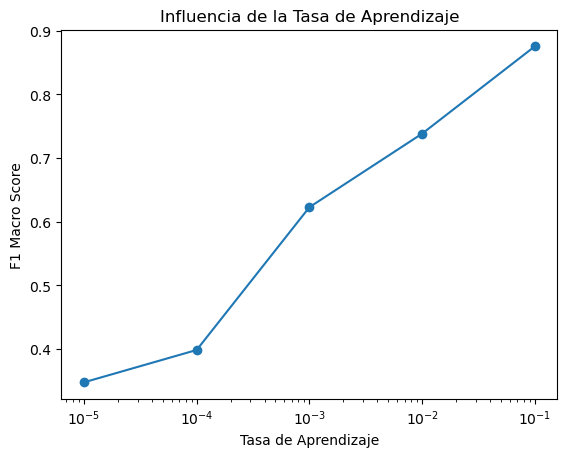

In [12]:
df_lr = pd.DataFrame(results_lr)
plt.figure()
plt.plot(df_lr['learning_rate'], df_lr['f1_macro'], marker='o')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('F1 Macro Score')
plt.title('Influence of the learning rate')
plt.show()

### 2.2 Batch size

Next, we evaluate the model with different batch sizes and print out the F1 macro scores to determine which batch size works best for our problem.

In [13]:
batch_sizes = [8, 16, 32, 64, 128]
results_bs = []

for bs in batch_sizes:
    model = create_model(learning_rate=0.001, input_dim=input_dim)
    f1_macro = train_and_evaluate_model(model, X_train, y_train, X_test, y_test, batch_size=bs)
    results_bs.append({'batch_size': bs, 'f1_macro': f1_macro})
    print(f"Batch size: {bs}, F1 Macro Score: {f1_macro:.4f}")

1/1 [==============================] - 0s 31ms/step
Batch size: 8, F1 Macro Score: 0.8102
1/1 [==============================] - 0s 39ms/step
Batch size: 16, F1 Macro Score: 0.7138
1/1 [==============================] - 0s 31ms/step
Batch size: 32, F1 Macro Score: 0.4021
1/1 [==============================] - 0s 32ms/step
Batch size: 64, F1 Macro Score: 0.4444
1/1 [==============================] - 0s 31ms/step
Batch size: 128, F1 Macro Score: 0.3268


This information, visually, looks as follows:

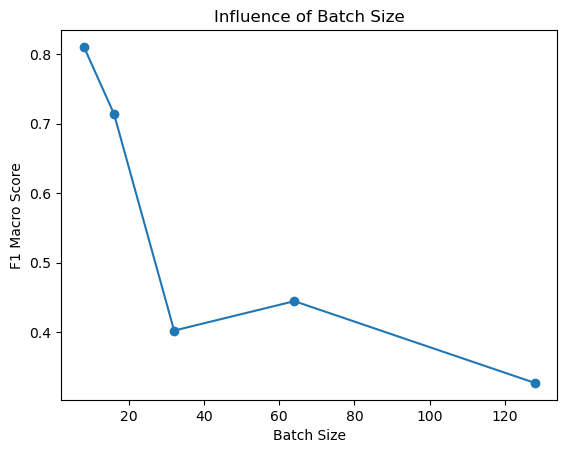

In [38]:
df_bs = pd.DataFrame(results_bs)
plt.figure()
plt.plot(df_bs['batch_size'], df_bs['f1_macro'], marker='o')
plt.xlabel('Batch Size')
plt.ylabel('F1 Macro Score')
plt.title('Influence of Batch Size')
plt.show()

### 2.3 Architecture

Next, we define several different neural network architectures to be tested (each architecture is represented as a list of integers, where each integer represents the number of neurons in a particular). Then iterate over each architecture to create, train, and evaluate a model.

In [15]:
architectures = [
    [32],
    [64],
    [128],
    [64, 32],
    [128, 64, 32],
    [256, 128, 64],
    [64, 64, 32],
    [128, 64, 16]
]
results_arch = []

for arch in architectures:
    model = create_model(learning_rate=0.001, architecture=arch, input_dim=input_dim)
    f1_macro = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
    results_arch.append({'architecture': arch, 'f1_macro': f1_macro})
    arch_str = '-'.join(map(str, arch))
    print(f"Architecture: {arch_str}, F1 Macro Score: {f1_macro:.4f}")

1/1 [==============================] - 0s 31ms/step
Architecture: 32, F1 Macro Score: 0.4765
1/1 [==============================] - 0s 33ms/step
Architecture: 64, F1 Macro Score: 0.2949
1/1 [==============================] - 0s 37ms/step
Architecture: 128, F1 Macro Score: 0.7138
1/1 [==============================] - 0s 37ms/step
Architecture: 64-32, F1 Macro Score: 0.4107
1/1 [==============================] - 0s 31ms/step
Architecture: 128-64-32, F1 Macro Score: 0.5306
1/1 [==============================] - 0s 49ms/step
Architecture: 256-128-64, F1 Macro Score: 0.6782
1/1 [==============================] - 0s 45ms/step
Architecture: 64-64-32, F1 Macro Score: 0.6250
1/1 [==============================] - 0s 47ms/step
Architecture: 128-64-16, F1 Macro Score: 0.3922


This information, visually, looks as follows:

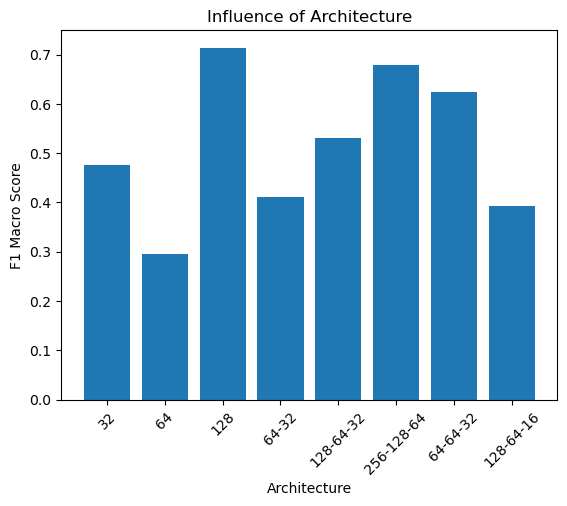

In [39]:
df_arch = pd.DataFrame(results_arch)
df_arch['architecture_str'] = df_arch['architecture'].apply(lambda x: '-'.join(map(str, x)))

plt.figure()
plt.bar(df_arch['architecture_str'], df_arch['f1_macro'])
plt.xlabel('Architecture')
plt.ylabel('F1 Macro Score')
plt.title('Influence of Architecture')
plt.xticks(rotation=45)
plt.show()

### 2.4 Number iterations 

We evaluate the effect of the number of training iterations on the model's performance. We define different values for the number of iterations to test, then iterate over each value to train and evaluate the model. We record the F1 macro score for each iteration count to determine the impact of training duration.

In [17]:
epochs_list = [10, 50, 100, 200]
results_epochs = []

for epochs in epochs_list:
    model = create_model(learning_rate=0.001, input_dim=input_dim)
    f1_macro = train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=epochs)
    results_epochs.append({'epochs': epochs, 'f1_macro': f1_macro})
    print(f"Epochs: {epochs}, F1 Macro Score: {f1_macro:.4f}")

1/1 [==============================] - 0s 38ms/step
Epochs: 10, F1 Macro Score: 0.5098
1/1 [==============================] - 0s 31ms/step
Epochs: 50, F1 Macro Score: 0.8755
1/1 [==============================] - 0s 31ms/step
Epochs: 100, F1 Macro Score: 0.8755
1/1 [==============================] - 0s 47ms/step
Epochs: 200, F1 Macro Score: 0.9052


This information, visually, looks as follows:

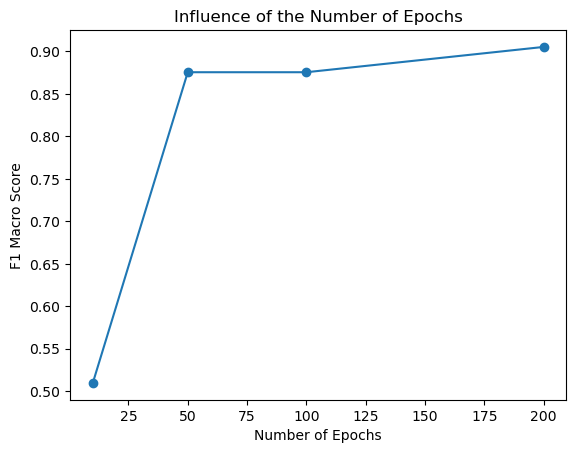

In [40]:
df_epochs = pd.DataFrame(results_epochs)
plt.figure()
plt.plot(df_epochs['epochs'], df_epochs['f1_macro'], marker='o')
plt.xlabel('Number of Epochs')
plt.ylabel('F1 Macro Score')
plt.title('Influence of the Number of Epochs')
plt.show()

## 3. Select the best hyperparams configuration

In this section, we aim to determine the best hyperparameter configuration by comparing different parameters. For this purpose, we define a function `train_and_evaluate_model` to create and evaluate the model. The function uses several key parameters:
- `learning_rate`: The learning rate for the optimizer, which controls how much to adjust the model weights during training.
- `batch_size`: The number of samples processed before the model is updated.
- `architecture`: A list representing the number of neurons in each layer of the neural network.
- `epochs`: The number of complete passes through the training dataset.

In [19]:
def train_and_evaluate_model(learning_rate, batch_size, architecture, epochs, input_dim, X_train, y_train, X_test, y_test):
    model = create_model(learning_rate=learning_rate, architecture=architecture, input_dim=input_dim)
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    f1_macro = f1_score(y_true, y_pred, average='macro')
    return f1_macro

The parameters we have used are:

In [20]:
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
batch_sizes = [8, 16, 32, 64, 128]
architectures = [
    [32],
    [64],
    [128],
    [64, 32],
    [128, 64, 32],
    [256, 128, 64],
    [64, 64, 32],
    [128, 64, 16]
]
epochs_list = [10, 50, 100, 200]

param_grid = list(itertools.product(learning_rates, batch_sizes, architectures, epochs_list))

Once the function is created and parameterized, with all parameter combinations stored in a grid (`param_grid`), we train and evaluate the model for each combination. The results are then stored for later comparison to identify the optimal configuration.

In [21]:
results = []

input_dim = X_train.shape[1]

for lr, bs, arch, ep in param_grid:
    f1_macro = train_and_evaluate_model(
        learning_rate=lr,
        batch_size=bs,
        architecture=arch,
        epochs=ep,
        input_dim=input_dim,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

    results.append({
        'learning_rate': lr,
        'batch_size': bs,
        'architecture': arch,
        'epochs': ep,
        'f1_macro': f1_macro
    })
    print(f"Tasa de aprendizaje: {lr}, Tamaño de lote: {bs}, Arquitectura: {arch}, Epochs: {ep}, F1 Macro: {f1_macro:.4f}")

1/1 [==============================] - 0s 31ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 8, Arquitectura: [32], Epochs: 10, F1 Macro: 0.5945
1/1 [==============================] - 0s 44ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 8, Arquitectura: [32], Epochs: 50, F1 Macro: 0.2143
1/1 [==============================] - 0s 31ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 8, Arquitectura: [32], Epochs: 100, F1 Macro: 0.5396
1/1 [==============================] - 0s 31ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 8, Arquitectura: [32], Epochs: 200, F1 Macro: 0.4781
1/1 [==============================] - 0s 39ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 8, Arquitectura: [64], Epochs: 10, F1 Macro: 0.4158
1/1 [==============================] - 0s 31ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 8, Arquitectura: [64], Epochs: 50, F1 Macro: 0.1890
1/1 [==============================] - 0s 32ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 8, Arquitectur

1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 100, F1 Macro: 0.2424
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 200, F1 Macro: 0.5051
1/1 [==============================] - 0s 31ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 10, F1 Macro: 0.1600
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 50, F1 Macro: 0.2731
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 100, F1 Macro: 0.2505
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 1e-05, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 200, F1 Macro: 0.5940
1/1 [==============================] - 0s 47ms/ste

1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 8, Arquitectura: [32], Epochs: 10, F1 Macro: 0.4788
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 8, Arquitectura: [32], Epochs: 50, F1 Macro: 0.5880
1/1 [==============================] - 0s 59ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 8, Arquitectura: [32], Epochs: 100, F1 Macro: 0.2999
1/1 [==============================] - 0s 50ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 8, Arquitectura: [32], Epochs: 200, F1 Macro: 0.7138
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 8, Arquitectura: [64], Epochs: 10, F1 Macro: 0.4989
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 8, Arquitectura: [64], Epochs: 50, F1 Macro: 0.5022
1/1 [==============================] - 0s 53ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 8, Arqu

1/1 [==============================] - 0s 206ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 64, Arquitectura: [128], Epochs: 100, F1 Macro: 0.4706
1/1 [==============================] - 0s 94ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 64, Arquitectura: [128], Epochs: 200, F1 Macro: 0.5051
1/1 [==============================] - 0s 159ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 10, F1 Macro: 0.1444
1/1 [==============================] - 0s 114ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 50, F1 Macro: 0.4287
1/1 [==============================] - 0s 63ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 100, F1 Macro: 0.4714
1/1 [==============================] - 0s 61ms/step
Tasa de aprendizaje: 0.0001, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 200, F1 Macro: 0.4333
1/1 [==============================] - 0s 50ms/step
Tasa de aprendizaje: 0.

1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 10, F1 Macro: 0.8399
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 50, F1 Macro: 0.8374
1/1 [==============================] - 0s 69ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 100, F1 Macro: 0.8374
1/1 [==============================] - 0s 60ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 200, F1 Macro: 0.8374
1/1 [==============================] - 0s 63ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 10, F1 Macro: 0.5294
1/1 [==============================] - 0s 53ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 50, F1 Macro: 0.8102
1/1 [==============================] - 0s 84ms/s

1/1 [==============================] - 0s 62ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 64, Arquitectura: [128], Epochs: 50, F1 Macro: 0.7138
1/1 [==============================] - 0s 52ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 64, Arquitectura: [128], Epochs: 100, F1 Macro: 0.7864
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 64, Arquitectura: [128], Epochs: 200, F1 Macro: 0.8755
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 10, F1 Macro: 0.5011
1/1 [==============================] - 0s 63ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 50, F1 Macro: 0.7138
1/1 [==============================] - 0s 63ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 100, F1 Macro: 0.8755
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.001, Tamaño d

1/1 [==============================] - 0s 63ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 128, Arquitectura: [128, 64, 16], Epochs: 100, F1 Macro: 0.8755
1/1 [==============================] - 0s 48ms/step
Tasa de aprendizaje: 0.001, Tamaño de lote: 128, Arquitectura: [128, 64, 16], Epochs: 200, F1 Macro: 0.8374
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 8, Arquitectura: [32], Epochs: 10, F1 Macro: 0.8474
1/1 [==============================] - 0s 63ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 8, Arquitectura: [32], Epochs: 50, F1 Macro: 0.8374
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 8, Arquitectura: [32], Epochs: 100, F1 Macro: 0.8374
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 8, Arquitectura: [32], Epochs: 200, F1 Macro: 0.8755
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.01, Tamaño de l

1/1 [==============================] - 0s 76ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 10, F1 Macro: 0.8755
1/1 [==============================] - 0s 84ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 50, F1 Macro: 0.8374
1/1 [==============================] - 0s 91ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 100, F1 Macro: 0.8374
1/1 [==============================] - 0s 93ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 200, F1 Macro: 0.8374
1/1 [==============================] - 0s 78ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 10, F1 Macro: 0.8474
1/1 [==============================] - 0s 79ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 50, F1 Macro: 0.8102
1/1 [==============================] - 0s 78ms/step
Ta

Tasa de aprendizaje: 0.01, Tamaño de lote: 64, Arquitectura: [128], Epochs: 50, F1 Macro: 0.8755
1/1 [==============================] - 0s 31ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 64, Arquitectura: [128], Epochs: 100, F1 Macro: 0.8374
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 64, Arquitectura: [128], Epochs: 200, F1 Macro: 0.8374
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 10, F1 Macro: 0.7383
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 50, F1 Macro: 0.8755
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 100, F1 Macro: 0.8374
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.01, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 200, F1 Macro: 

1/1 [==============================] - 0s 48ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 10, F1 Macro: 0.8261
1/1 [==============================] - 0s 60ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 50, F1 Macro: 0.4437
1/1 [==============================] - 0s 60ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 100, F1 Macro: 0.4577
1/1 [==============================] - 0s 63ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 16, Arquitectura: [256, 128, 64], Epochs: 200, F1 Macro: 0.6899
1/1 [==============================] - 0s 62ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 10, F1 Macro: 0.6875
1/1 [==============================] - 0s 63ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 16, Arquitectura: [64, 64, 32], Epochs: 50, F1 Macro: 0.6663
1/1 [==============================] - 0s 79ms/step
Tasa de 

1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 64, Arquitectura: [128], Epochs: 100, F1 Macro: 0.8374
1/1 [==============================] - 0s 48ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 64, Arquitectura: [128], Epochs: 200, F1 Macro: 0.8755
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 10, F1 Macro: 0.8233
1/1 [==============================] - 0s 56ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 50, F1 Macro: 0.8755
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 100, F1 Macro: 0.8374
1/1 [==============================] - 0s 47ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 64, Arquitectura: [64, 32], Epochs: 200, F1 Macro: 0.8755
1/1 [==============================] - 0s 56ms/step
Tasa de aprendizaje: 0.1, Tamaño de lote: 64

After performing all iterations, the parameters of the model that obtains the best F1 Macro Score, together with that value, are:

In [41]:
results_df = pd.DataFrame(results)

best_result = results_df.loc[results_df['f1_macro'].idxmax()]
print("\nBest Hyperparameter Configuration:")
print(f"Learning Rate: {best_result['learning_rate']}")
print(f"Batch Size: {best_result['batch_size']}")
print(f"Architecture: {best_result['architecture']}")
print(f"Epochs: {best_result['epochs']}")
print(f"Best F1 Macro Score: {best_result['f1_macro']:.4f}")


Best Hyperparameter Configuration:
Learning Rate: 0.0001
Batch Size: 8
Architecture: [256, 128, 64]
Epochs: 100
Best F1 Macro Score: 0.9052


### 3.1 Brief discussion of the experimental procedure, along with the results obtained

After testing each parameter and obtaining the best configuration, the results are as follows:

1. **Learning Rate**: An increasing trend in F1 Macro Score was observed with higher learning rates. The lowest rate (1e-05) showed the poorest performance, while the optimal value of 0.1 reached the highest performance (F1 Macro Score of 0.8755).

2. **Batch Size**: A batch size of 8 provided the best performance (F1 Macro Score of 0.8102). As the batch size increased, performance dropped, reaching its lowest point with a batch size of 128.

3. **Network Architecture**: Deeper configurations, such as [256, 128, 64], demonstrated solid performance (F1 Macro Score of 0.6782), while the single-layer architecture [128] achieved a score of 0.7138, indicating that higher network capacity may capture the problem's complexity better.

4. **Epochs**: Models trained with 200 epochs reached the highest score of 0.9052, suggesting that extended training allows the model to capture more complex patterns, thus improving performance.

The optimal hyperparameter configuration was determined after evaluating the individual impact of each parameter on the F1 Macro Score. Here’s how this configuration relates to the individual results:

- **Learning Rate**: Although higher learning rates showed improvements, the best configuration used a rate of 0.0001. This suggests that, in combination with the other parameters, a lower learning rate allowed the model to capture patterns effectively without overfitting.

- **Batch Size**: Individually, a batch size of 8 stood out, confirming that smaller batch sizes enhance model accuracy when trained with a low learning rate. This suggests a synergy between gradual learning and smaller batches that improve precision.

- **Architecture**: While deeper configurations like [256, 128, 64] showed decent performance in individual trials, this complex architecture excelled when combined with the ideal parameters, demonstrating its capacity to model the problem’s complexity effectively.

- **Epochs**: The highest score obtained with 200 epochs further supports the idea that extended training optimizes performance when using careful learning configurations. Although the performance was positive with 100 epochs in individual testing, extending the training maintained superior performance, maximizing the effectiveness of the architecture and other parameters.

In summary, this configuration achieved the best F1 Macro Score of 0.9052, highlighting how the interaction between these hyperparameters optimizes performance rather than relying on isolated results.


### 3.2 Estimate model performance with the validation set

We concatenate the training and test datasets (`X_train`, `X_test`, `y_train`, `y_test`) to create a complete dataset (`X_full` and `y_full`) that contains all available data. This complete dataset will be used for further validation through cross-validation. The concatenated datasets are reset to drop any existing index to ensure consistency.

Next, we convert the one-hot encoded labels (`y_full`) into class labels using `np.argmax`. This step provides a single label for each sample, which will be useful for cross-validation.

In [23]:
X_full = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y_full = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

y_full_labels = np.argmax(y_full.values, axis=1)

To prepare for cross-validation, the full feature (`X_full_values`) and label datasets (`y_full_values`, `y_full_labels`) are readied. Here, `y_full_labels` contains the numeric class labels.

Class names are defined for the different types of tumors being classified: 'ASTROCYTOMA,' 'GLIOBLASTOMA,' and 'MENINGIOMA.' Next, StratifiedKFold with 5 splits is employed to ensure that each fold maintains the same proportion of class labels, which is especially useful in managing class imbalance.

Lists are initialized to store metrics (precision, recall, F1-score, AUC) for each fold during the cross-validation process. For each fold, the data is split into training and validation sets. The model is then trained using the best hyperparameters identified earlier. Precision, recall, F1-score, and AUC are calculated for each tumor type, providing an estimate of the model's performance across all folds. Finally, the metrics are averaged across all folds, and the results are printed for each class.

In [24]:
X_full_values = X_full.values
y_full_values = y_full.values  
y_full_labels = np.argmax(y_full_values, axis=1)

class_names = ['ASTROCYTOMA', 'GLIOBLASTOMA', 'MENINGIOMA']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

precision_scores = []
recall_scores = []
f1_scores = []
auc_scores = []

for train_index, val_index in skf.split(X_full_values, y_full_labels):
    X_train_cv, X_val_cv = X_full_values[train_index], X_full_values[val_index]
    y_train_cv, y_val_cv = y_full_values[train_index], y_full_values[val_index]
    y_val_labels = y_full_labels[val_index]
    
    model_cv = create_model(
        learning_rate=best_result['learning_rate'],
        architecture=best_result['architecture'],
        input_dim=X_full_values.shape[1]
    )
    
    model_cv.fit(
        X_train_cv,
        y_train_cv,
        batch_size=best_result['batch_size'],
        epochs=int(best_result['epochs']),
        verbose=0
    )
    
    y_pred_prob = model_cv.predict(X_val_cv)
    y_pred_labels = np.argmax(y_pred_prob, axis=1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_val_labels, y_pred_labels, average=None, labels=[0,1,2])
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    
    y_val_binarized = y_val_cv
    auc = roc_auc_score(y_val_binarized, y_pred_prob, average=None, multi_class='ovr')
    auc_scores.append(auc)

mean_precision = np.mean(precision_scores, axis=0)
mean_recall = np.mean(recall_scores, axis=0)
mean_f1 = np.mean(f1_scores, axis=0)
mean_auc = np.mean(auc_scores, axis=0)

for idx, class_name in enumerate(class_names):
    print(f"\nMetrics for {class_name}:")
    print(f"Precision: {mean_precision[idx]:.4f}")
    print(f"Recall: {mean_recall[idx]:.4f}")
    print(f"F1-Score: {mean_f1[idx]:.4f}")
    print(f"AUC: {mean_auc[idx]:.4f}")

1/1 [==============================] - 0s 69ms/step

Métricas para ASTROCYTOMA:
Precisión: 0.6933
Recall: 0.6700
F1-Score: 0.6605
AUC: 0.9057

Métricas para GLIOBLASTOMA:
Precisión: 0.7533
Recall: 0.6833
F1-Score: 0.6948
AUC: 0.8922

Métricas para MENINGIOMA:
Precisión: 0.8365
Recall: 0.8673
F1-Score: 0.8431
AUC: 0.9023


The explanation of the results is as follows:

- The **ASTROCYTOMA** metrics suggest a moderate performance, with relatively balanced precision and recall values. The F1-score indicates that there is room for improvement in both precision and recall. Notably, the high AUC suggests that the model has a good ability to distinguish between classes for ASTROCYTOMA.

- For **GLIOBLASTOMA**, the precision is higher than the recall, indicating that while there are fewer false positives, some true positives might be missed. The F1-score reflects a balanced approach to both metrics. The AUC is slightly lower than for ASTROCYTOMA, but still suggests good discriminative capability.

- The metrics for **MENINGIOMA** are the highest among the three classes. High precision and recall values indicate strong model performance, with the F1-score confirming a well-balanced approach. The AUC remains high, suggesting the model reliably distinguishes MENINGIOMA from other tumor types.

### 3.3 Retrain your model with the whole training data, considering the best hyperparams set

The model is retrained using the entire training dataset, applying the optimal hyperparameter configuration identified during the tuning process. This setup leverages the best learning rate, architecture, and input dimension, and trains the model using the selected batch size and number of epochs.

Upon retraining, the model’s performance is evaluated on the test set to measure its effectiveness. The macro F1 score is computed, and a comprehensive classification report is generated, detailing metrics such as precision, recall, and F1 score for each class (ASTROCYTOMA, GLIOBLASTOMA, MENINGIOMA). This analysis offers an in-depth view of how well the model performs across each specific category.

In [42]:
best_model = create_model(
    learning_rate=best_result['learning_rate'],
    architecture=best_result['architecture'],
    input_dim=input_dim
)

history = best_model.fit(
            X_train,
            y_train,
            batch_size=best_result['batch_size'],
            epochs=int(best_result['epochs']),
            verbose=0
        )

y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f"\nF1 Macro Score of Best Model: {f1_macro:.4f}")


label_mapping = {'ASTROCYTOMA': 0, 'GLIOBLASTOMA': 1, 'MENINGIOMA': 2}
print("\nRanking Report for the Best Model:")
print(classification_report(y_true, y_pred, target_names=label_mapping.keys()))

1/1 [==============================] - 0s 96ms/step

F1 Macro Score of Best Model: 0.8755

Ranking Report for the Best Model:
              precision    recall  f1-score   support

 ASTROCYTOMA       0.75      0.86      0.80         7
GLIOBLASTOMA       1.00      0.80      0.89         5
  MENINGIOMA       0.94      0.94      0.94        16

    accuracy                           0.89        28
   macro avg       0.90      0.86      0.88        28
weighted avg       0.90      0.89      0.89        28



The following code creates a plot that illustrates the training loss over the course of the epochs, providing insight into the model's convergence during training. The `loss` values, obtained from the model's training history, are plotted to show how the loss changes with each epoch.

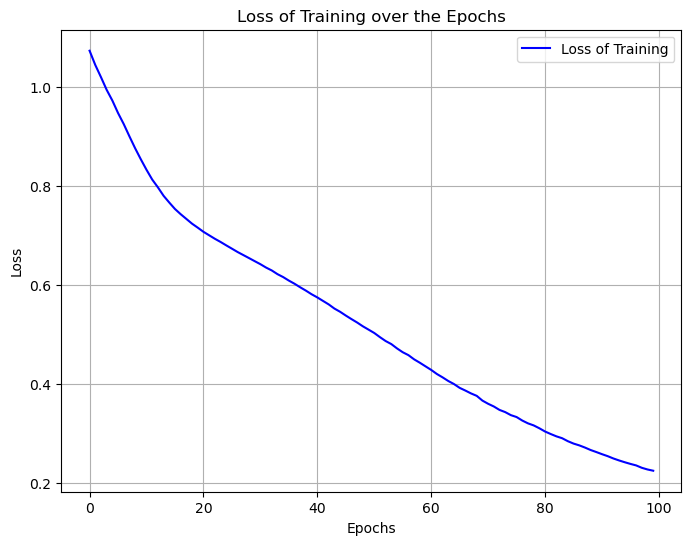

In [43]:
loss = history.history['loss']

# Crear la figura
plt.figure(figsize=(8,6))
plt.plot(loss, label='Loss of Training', color='blue')
plt.title('Loss of Training over the Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The plot shows a clear downward trend in the training loss over 100 epochs, indicating that the model is learning effectively. The loss decreases consistently, which suggests that the model is gradually improving its fit to the training data.

At the beginning, the loss decreases rapidly, which is typical as the model learns general patterns. As the epochs progress, the rate of decrease becomes slower, approaching a plateau. This behavior is expected as the model converges, showing less drastic improvements in later epochs.

Overall, the steady decline in loss without sudden increases suggests that the model is not overfitting and is achieving stable learning throughout the training process.

Finally, we save the model that obtains the best results, in order to use it in the application.

In [31]:
best_model.save('mejor_modelo.h5')

# Block III. Clinical decision support system deployment

You can see the code here, but it cannot be executed (In *app.py*, it can be done).

In addition, the application can be consulted at [this link](https://brain-tumor-diagnosis-bds.streamlit.app/).

In [37]:
# import streamlit as st
# import pandas as pd
# import re
# import numpy as np
# from tensorflow.keras.models import load_model
# from sklearn.preprocessing import RobustScaler
# import joblib  

# # Título de la aplicación
# st.title("Prediction of Brain Tumor Diagnosis")

# st.write("""
# This application allows uploading data of metabolite concentrations to predict brain tumor type.
# """)

# # Cargar el modelo guardado
# @st.cache_resource
# def load_saved_model():
#     model = load_model('mejor_modelo.h5')
#     return model

# # Cargar el escalador guardado
# @st.cache_resource
# def load_scaler():
#     scaler = joblib.load('robust_scaler.joblib')
#     return scaler

# model = load_saved_model()
# scaler = load_scaler()

# # Cargar el archivo CSV de entrada
# uploaded_file = st.file_uploader("Upload a CSV file with metabolite concentrations.", type=["csv"])

# if uploaded_file is not None:
#     # Leer el archivo CSV
#     input_data = pd.read_csv(uploaded_file, sep = ";", usecols=range(1,16))

#     metabolite_columns = input_data.columns[input_data.columns != 'TYPE']
    
#     def clean_number_format(value):
#         # Eliminar todas las comas y cualquier punto existente
#         cleaned_value = re.sub(r'[,.]', '', value)
        
#         # Insertar un punto después del primer dígito
#         cleaned_value = f"{cleaned_value[0]}.{cleaned_value[1:]}"
        
#         return cleaned_value

#     # Aplicar la función de limpieza y luego convertir a float
#     input_data[metabolite_columns] = input_data[metabolite_columns].apply(
#         lambda col: col.str.replace(',', '.').apply(clean_number_format).astype(float)
#     )    

#     st.write("Data loaded:")
#     st.write(input_data.head())

#     # Verificar si las columnas necesarias están presentes
#     required_columns = [f"METABOLITE {i}" for i in range(15)]  # Lista de nombres de columnas de metabolitos esperados
#     if all(col in input_data.columns for col in required_columns):
#         # Preprocesar los datos
#         X_input = input_data[required_columns]
#         X_scaled = scaler.transform(X_input)
        
#         # Realizar las predicciones
#         predictions = model.predict(X_scaled)
        
#         # Obtener las probabilidades y el diagnóstico recomendado
#         diagnosis_classes = ['ASTROCYTOMA', 'GLIOBLASTOMA', 'MENINGIOMA']
#         predicted_classes = np.argmax(predictions, axis=1)
#         predicted_labels = [diagnosis_classes[i] for i in predicted_classes]
        
#         # Crear un DataFrame con los resultados
#         results = input_data.copy()
#         for idx, diagnosis in enumerate(diagnosis_classes):
#             results[f'Probability_{diagnosis}'] = predictions[:, idx]
#         results['Diagnosis_Prediction'] = predicted_labels
        
#         st.write("Prediction results:")
#         st.write(results.head())
        
#         # Botón para descargar los resultados
#         @st.cache_data
#         def convert_df(df):
#             return df.to_csv(index=False).encode('utf-8')
        
#         csv = convert_df(results)
        
#         st.download_button(
#             label="Download results as CSV",
#             data=csv,
#             file_name='prediction_results.csv',
#             mime='text/csv',
#         )
#     else:
#         st.error("The CSV file does not contain the required columns. Please check the file format.")